### Using the basic preprocessing module of `s2spy`

To start we need to import the `preprocess` module, and load in some example data:


In [1]:
import xarray as xr
from s2spy import preprocess
import matplotlib.pyplot as plt

file_path = '../../tests/test_rgdr/test_data'
data = xr.open_dataset(f'{file_path}/sst_daily_1979-2018_5deg_Pacific_175_240E_25_50N.nc')

The preprocessor is instatiated with the basic settings, the size of the rolling window, the detrending method, and if climatology should be removed from the data.

In [2]:
preprocessor = preprocess.Preprocessor(
    rolling_window_size=25,
    detrend="linear",
    subtract_climatology=True,
)

The preprocesssor can be fit to data, which updates the preprocessor object in place, storing the trend and climatology:

In [3]:
preprocessor.fit(data)

In [4]:
preprocessor.trend

{'slope': <xarray.Dataset>
 Dimensions:    (latitude: 5, longitude: 13)
 Coordinates:
   * latitude   (latitude) float64 47.5 42.5 37.5 32.5 27.5
   * longitude  (longitude) float64 177.5 182.5 187.5 192.5 ... 227.5 232.5 237.5
 Data variables:
     sst        (latitude, longitude) float64 4.581e-19 4.763e-19 ... 1.376e-19,
 'intercept': <xarray.Dataset>
 Dimensions:    (latitude: 5, longitude: 13)
 Coordinates:
   * latitude   (latitude) float64 47.5 42.5 37.5 32.5 27.5
   * longitude  (longitude) float64 177.5 182.5 187.5 192.5 ... 227.5 232.5 237.5
 Data variables:
     sst        (latitude, longitude) float64 -0.4192 -0.4358 ... -0.2372 -0.126}

Now the climatology and trend will be stored in `preprocessor`. 

In the example case the climatology of one location is stored as follows:

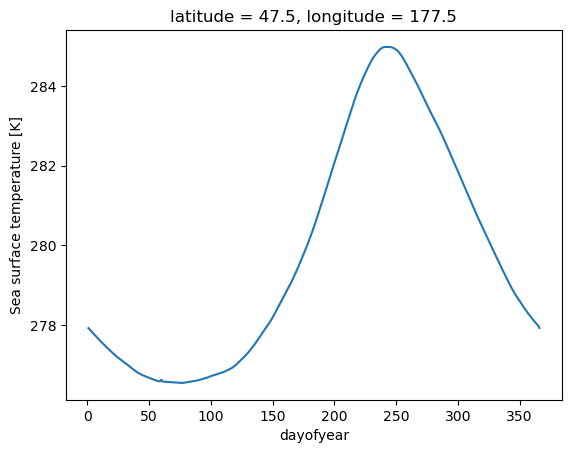

In [5]:
preprocessor.climatology["sst"].isel(latitude=0, longitude=0).plot()

The trend has multiple components, depending on the method. The "linear" method has a slope and an intercept. (Currently, only linear detrending is implemented). 

The example data has already been detrended, so its slope is (basically) 0:

In [6]:
preprocessor.trend["slope"].sst.isel(latitude=0, longitude=0).values

array(4.580899e-19)

To apply the detrending and climatology removal to a dataset, the `transform` method is used:

In [7]:
preprocessed_data = preprocessor.transform(data)

Text(0.5, 1.0, 'Detrended and climatology removed')

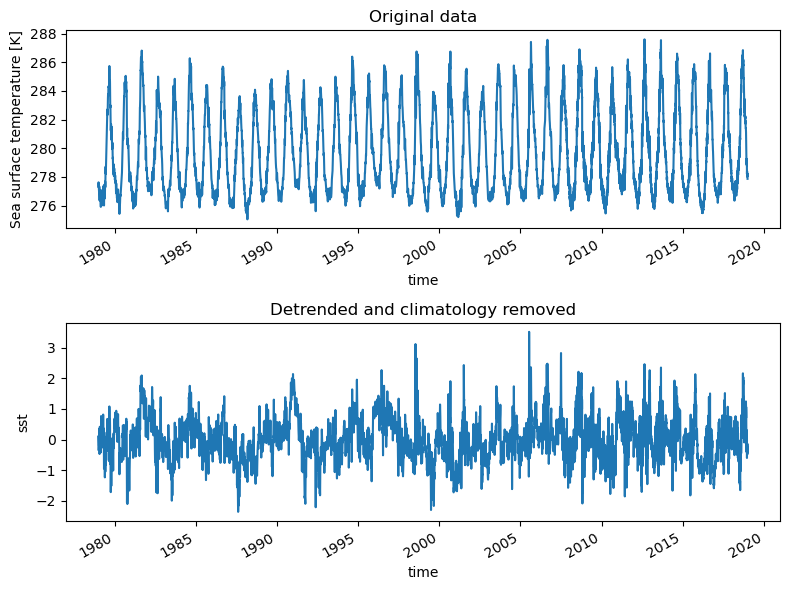

In [8]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(8, 6))
data.sst.isel(latitude=0, longitude=0).plot(ax=ax1)
preprocessed_data.sst.isel(latitude=0, longitude=0).plot(ax=ax2)
fig.tight_layout()
ax1.set_title("Original data")
ax2.set_title("Detrended and climatology removed")

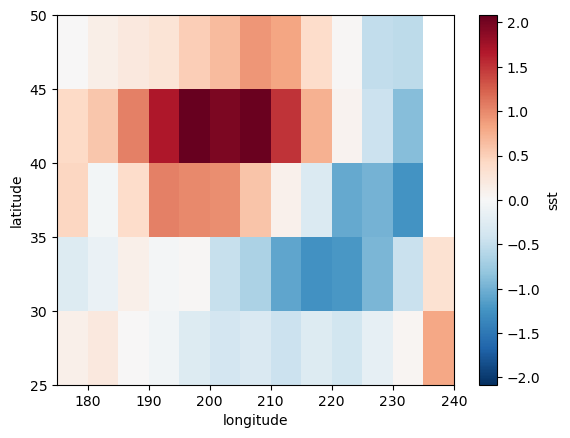

In [9]:
preprocessed_data.sst.sel(time=slice("1980-08-01", "1980-08-31")).mean(dim="time").plot()